In [1]:
# !python /home/vs428/Documents/deep-ed-diags/simple_nn_runner.py

# Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Path hack.
import sys
import os
sys.path.append(os.path.abspath('..'))

In [4]:
import csv
import ast
from datetime import date, datetime, time, timedelta
from datetime import datetime
import pickle as pkl
import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.utils.class_weight import compute_class_weight    

import numpy as np
import pandas as pd
import sklearn
from joblib import dump, load

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from models.simple_nn import *

In [5]:

def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]


def flatten(t):
    return [item for sublist in t for item in sublist]


# Read in Model

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.utils.class_weight import compute_class_weight    

import numpy as np
import pandas as pd
import sklearn
from joblib import dump, load

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from models.simple_nn import *

In [84]:
RUN_NAME = "different-vortex-252"

In [85]:
model = torch.load(f"/gpfs/milgram/project/rtaylor/shared/ABDPain_EarlyDiags/models/{RUN_NAME}.model")
model.eval()

AbdPainPredictionMLP(
  (fc1): Linear(in_features=1331, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=64, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [86]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Dataset

In [87]:
from sklearn.model_selection import cross_val_score
# from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold


import optuna


import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay

In [11]:
data = pd.read_pickle(
#     f"/gpfs/milgram/project/rtaylor/shared/ABDPain_EarlyDiags/unq_pt_enc_clean_multilabel_nomis_dvemb.pkl",
        f"/gpfs/milgram/project/rtaylor/shared/ABDPain_EarlyDiags/unq_pt_enc_clean_multilabel_nomismatches.pkl",
#                   nrows=50000
                  )


In [88]:
with open("../label_list.txt", "r") as f:
    label_list = f.read().splitlines()


In [89]:
label_list

['Abdominal Pain, general',
 'Abdominal aortic aneurysm',
 'Abdominal migraine',
 'Abortion',
 'Acute cystitis',
 'Acute gastroenteritis',
 'Aortic dissection',
 'Appendicitis',
 'Bowel obstruction',
 'Bowel perforation',
 'CHF',
 'Cholangitis',
 'Colitis',
 'Colon cancer',
 'Constipation',
 'Diabetic ketoacidosis',
 'Diverticulitis',
 'Ectopic pregnancy',
 'Flank pain/renal colic',
 'Gastritis',
 'Gastroesophageal reflux disease (GERD)',
 'Gastroparesis',
 'Glaucoma',
 'Hepatitis',
 'Hernia',
 'Herpes zoster',
 'Inflammatory Disease of the Uterus/Endometriosis',
 'Inflammatory bowel disease',
 'Irritable bowel syndrome',
 'Labor/Preterm Labor',
 "Meckel's diverticulum",
 'Mesenteric ischemia',
 'Mesenteric lymphadenitis',
 'Methanol Poisoning',
 'Mittelschmerz',
 'Mononucleosis',
 'Muscle spasm',
 'Myoma (degenerating)',
 'Ovarian cyst',
 'Pancreatitis',
 'Paroxysmal nocturnal hemoglobinuria',
 'Pelvic inflammatory disease',
 'Peptic ulcer disease with or without perforation',
 'Peric

In [90]:
from collections import Counter
value_counts = pd.Series(Counter(flatten(data['multilabel'].tolist())))

In [91]:
value_counts.sort_values()

Placental Abruption                        2
Paroxysmal nocturnal hemoglobinuria        3
Uremia                                     4
Porphyria                                  5
Labor/Preterm Labor                        6
                                       ...  
Constipation                            8518
Colitis                                 9023
Urolithiasis                           11358
Acute cystitis                         13418
Abdominal Pain, general                67113
Length: 64, dtype: int64

In [92]:
(value_counts.sum() - value_counts) / (value_counts)

Renal Failure                 50.144703
Appendicitis                  26.601023
Urolithiasis                  14.683835
Abdominal Pain, general        1.654285
Gastritis                     34.267670
                               ...     
Meckel's diverticulum      17812.700000
Glaucoma                   11874.800000
Uremia                     44533.250000
Porphyria                  35626.400000
Labor/Preterm Labor        29688.500000
Length: 64, dtype: float64

In [93]:

print(f"dataset size: {data.shape}")



dataset size: (162305, 2306)


In [94]:

def flatten(t):
    return [item for sublist in t for item in sublist]


In [95]:
non_train_col_mask = data.columns[data.columns.str.contains("EdDisposition_")].union(data.columns[:3], sort=False).union(pd.Index(['multilabel']), sort=False)
train_col_mask = data.columns.difference(non_train_col_mask, sort=False)



In [96]:
X_train, X_test, y_train, y_test = train_test_split(data[train_col_mask],
                                                    data['multilabel'],
                                                   test_size=0.2, random_state=314, 
                                                   )


In [97]:
#################
### Data Load ###
#################

std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()


# drop all columns that don't have any positive actual values/only have all NaNs
data = data.drop( data.columns[((data.shape[0]- data.isnull().sum()) == 0)], 
                 axis=1, errors='ignore' )

# remove columns that don't have at least N (hyperparam) number of non-NaN values
data = data[ data.columns.intersection(data.columns[(((data.shape[0]- data.isnull().sum())) > 5)]) ]
print(f"After dropping sparse columns: {data.shape}")

data.columns = data.columns.str.replace("[|]|<", "leq_")
# logging.info(f"Dropped {droppable_rows} rows for stratified K-fold with {single_support_classes} classes")

# drop EDDisposition, ID, and label columns
non_train_col_mask = data.columns[data.columns.str.contains("EdDisposition_")].union(data.columns[:3], sort=False).union(pd.Index(['multilabel']), sort=False)
train_col_mask = data.columns.difference(non_train_col_mask, sort=False)


After dropping sparse columns: (162305, 2306)


/gpfs/milgram/project/rtaylor/vs428/conda_envs/factcheck_env/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The default value of regex will change from True to False in a future version.


### read in col types that we used in model training

In [98]:
col_idxs = []
with open(f"/gpfs/milgram/project/rtaylor/shared/ABDPain_EarlyDiags/model_metadata/{RUN_NAME}_metadata.txt", 
          "r", encoding='unicode_escape') as f:
    for line in f:
        col_idxs.append(line)

In [99]:
import ast
cat_cols = ast.literal_eval(col_idxs[1])
normal_cols = ast.literal_eval(col_idxs[3])
all_other_cols = ast.literal_eval(col_idxs[5])
label_list = ast.literal_eval(col_idxs[7])

In [100]:

# Create a dummy index variable to get the indices
indices = range(data.shape[0])
X_train, X_test, y_train, y_test, idxs_train, idxs_test = train_test_split(data[train_col_mask],
                                                    data['multilabel'],
                                                    indices,
#                                                     stratify=train_test_stratify,
                                                   test_size=0.2, random_state=314, 
                                                   )

print(data[train_col_mask].shape)
print(X_train.shape)

# get the indices for the pandas column names 
cat_col_idxs = column_index(data[train_col_mask], train_col_mask.intersection(cat_cols))
normal_col_idxs = column_index(data[train_col_mask], train_col_mask.intersection(normal_cols))
all_other_cols_idxs = column_index(data[train_col_mask], train_col_mask.intersection(all_other_cols))


# fit the indices by data type
# we check if there are any such columns
# if not, this fails silently by indexing with empty arrays
if len(normal_col_idxs) > 0:
    std_scaler.fit(X_train.iloc[:, normal_col_idxs])
    X_train_std_scaled = std_scaler.transform(X_train.iloc[:, normal_col_idxs])
    X_test_std_scaled = std_scaler.transform(X_test.iloc[:, normal_col_idxs])
else:
    X_train_std_scaled = np.array([])
    X_test_std_scaled = np.array([])
    
if len(all_other_cols_idxs) > 0:
    minmax_scaler.fit(X_train.iloc[:, all_other_cols_idxs])
    X_train_minmax_scaled = minmax_scaler.transform(X_train.iloc[:, all_other_cols_idxs])
    X_test_minmax_scaled = minmax_scaler.transform(X_test.iloc[:, all_other_cols_idxs])
else:
    X_train_minmax_scaled = np.array([])
    X_test_minmax_scaled = np.array([])
    
# scale/normalize based on the column idxs above
X_train_input = torch.zeros(X_train.values.shape)
X_test_input = torch.zeros(X_test.values.shape)


(162305, 2292)
(129844, 2292)


In [101]:

### TODO: The error is in this line where the transform function expects what we trained on, which we aren't using here. terrible. 
X_train_input[:, cat_col_idxs] = torch.tensor(np.nan_to_num(X_train.iloc[:, cat_col_idxs]),
                                                 dtype=torch.float)

X_train_input[:, normal_col_idxs] = torch.tensor(np.nan_to_num(X_train_std_scaled),
                                                 dtype=torch.float)
X_train_input[:, all_other_cols_idxs] = torch.tensor(np.nan_to_num(X_train_minmax_scaled),
                                                     dtype=torch.float)


X_test_input[:, cat_col_idxs] = torch.tensor(np.nan_to_num(X_test.iloc[:, cat_col_idxs]),
                                                dtype=torch.float)
X_test_input[:, normal_col_idxs] = torch.tensor(np.nan_to_num(X_test_std_scaled),
                                                dtype=torch.float)
X_test_input[:, all_other_cols_idxs] = torch.tensor(np.nan_to_num(X_test_minmax_scaled),
                                                    dtype=torch.float)


In [102]:
X_train_input = X_train_input[:, list(cat_col_idxs) + list(normal_col_idxs) + list(all_other_cols_idxs)]
X_test_input = X_test_input[:, list(cat_col_idxs) + list(normal_col_idxs) + list(all_other_cols_idxs)]

In [103]:
X_train_input.shape, X_test_input.shape

(torch.Size([129844, 1331]), torch.Size([32461, 1331]))

In [104]:

# we need to store this value for the NN model definition
INPUT_DIM = X_train.shape[1]

# For the multilabel case, we have to transform the y_train and y_test datasets ourselves
y_train_input = torch.zeros(X_train_input.shape[0], len(label_list), dtype=torch.float)
y_test_input = torch.zeros(X_test_input.shape[0], len(label_list), dtype=torch.float)

for row_idx, (_, labels) in enumerate(y_train.items()):
    y_train_input[row_idx,:] = torch.tensor(np.isin(label_list, labels, assume_unique=True).astype(float))

for row_idx, (_, labels) in enumerate(y_test.items()):
    y_test_input[row_idx,:] = torch.tensor(np.isin(label_list, labels, assume_unique=True).astype(float))



In [105]:
X_train_input.shape, y_train_input.shape

(torch.Size([129844, 1331]), torch.Size([129844, 64]))

In [106]:
X_test_input.shape, y_test_input.shape

(torch.Size([32461, 1331]), torch.Size([32461, 64]))

In [107]:
model

AbdPainPredictionMLP(
  (fc1): Linear(in_features=1331, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=64, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [108]:

train_dataset = TensorDataset(X_train_input, y_train_input)
test_dataset = TensorDataset(X_test_input, y_test_input)

train_loader = DataLoader(train_dataset, batch_size=256,
#  collate_fn=collate_wrapper,
                    pin_memory=True)

test_loader = DataLoader(test_dataset, batch_size=256,
#  collate_fn=collate_wrapper,
                    pin_memory=True)


In [109]:
# y_pred = clf.predict_proba(X_test)
out = model(torch.tensor(X_test_input).float().to(device))

/gpfs/milgram/project/rtaylor/vs428/conda_envs/factcheck_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [110]:
out[out >= 0.5] = 1
out[out < 0.5] = 0 ## assign 0 label to those with less than 0.5


In [111]:
out.shape, y_test_input.shape

(torch.Size([32461, 64]), torch.Size([32461, 64]))

In [112]:
from sklearn.metrics import multilabel_confusion_matrix

In [113]:
conf_mat = multilabel_confusion_matrix(y_test_input.cpu().detach().numpy(), out.cpu().detach().numpy())

In [114]:
conf_mat.shape

(64, 2, 2)

In [115]:
y_test_input.shape

torch.Size([32461, 64])

In [116]:
conf_mat[40,:,:]

array([[32453,     8],
       [    0,     0]])

# Plot

In [117]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/gpfs/milgram/project/rtaylor/vs428/conda_envs/factcheck_env/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


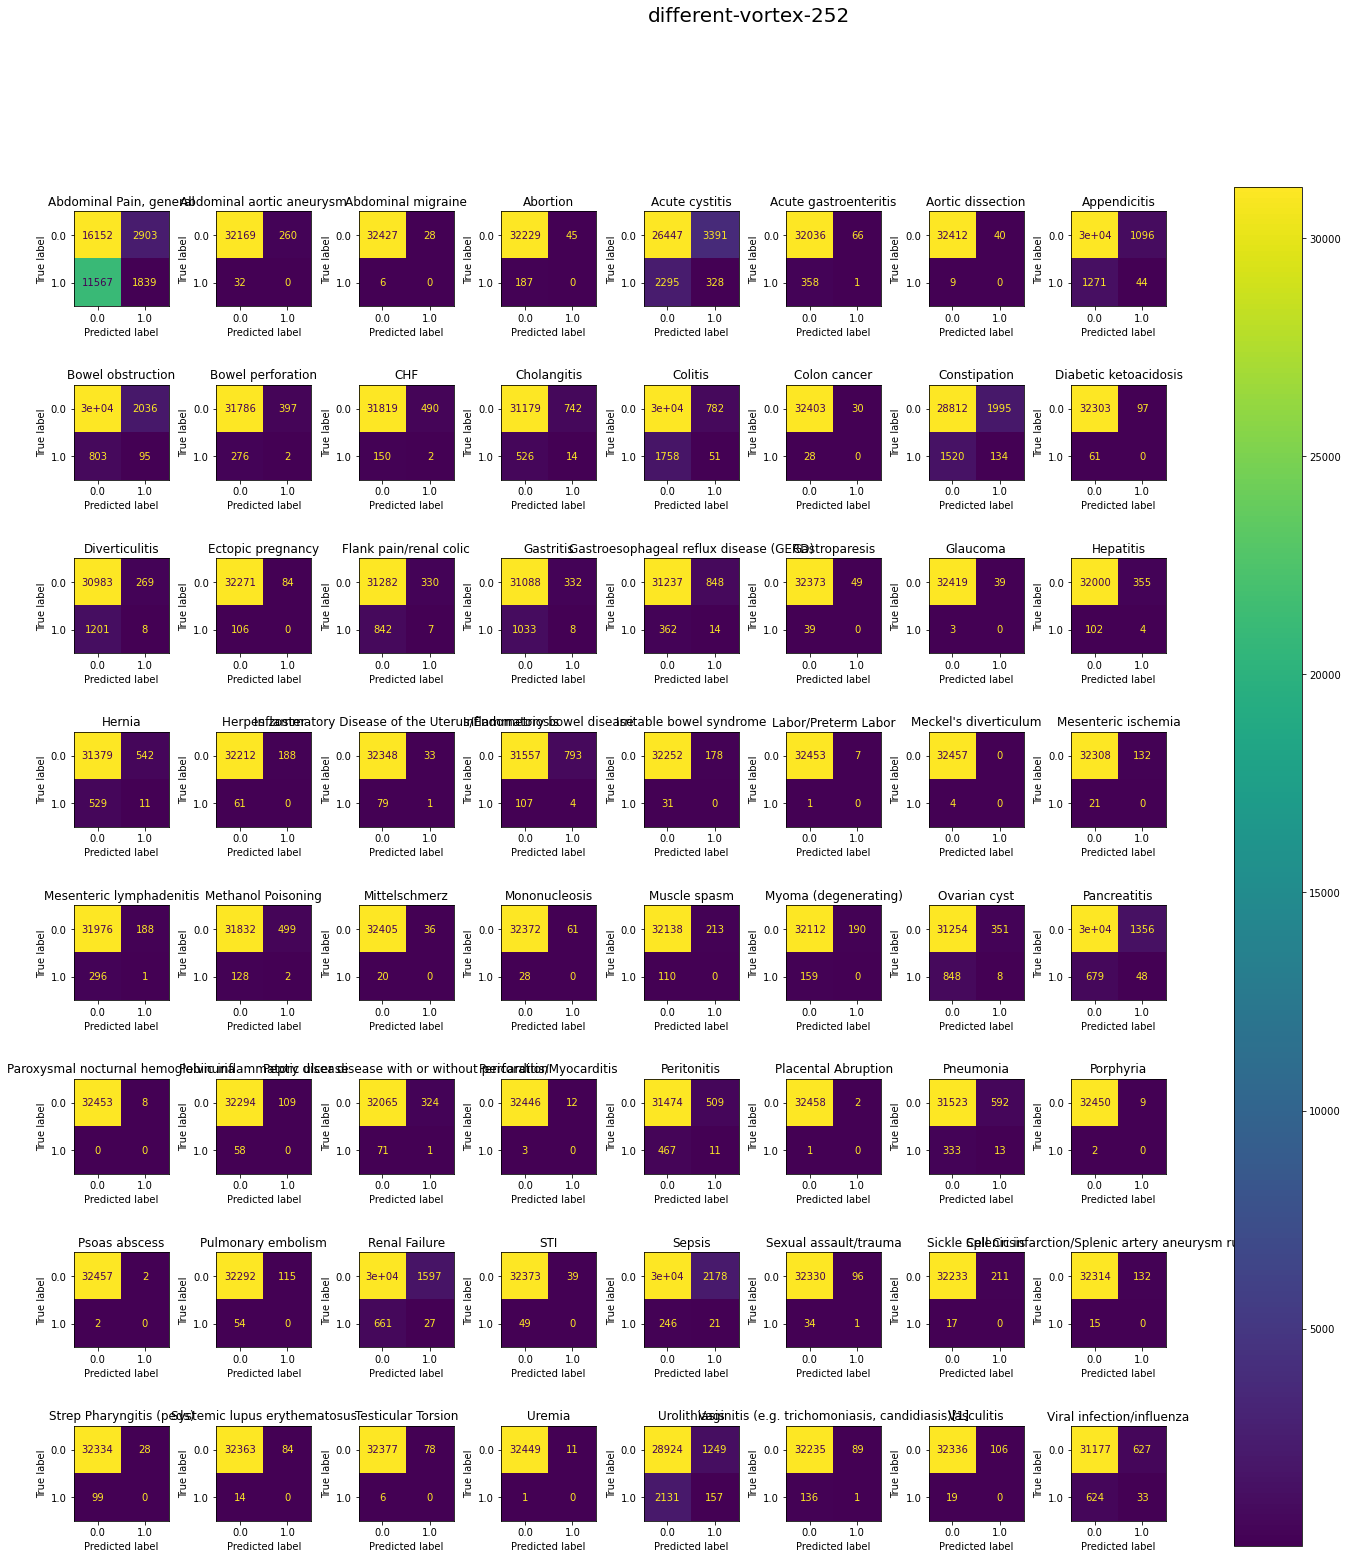

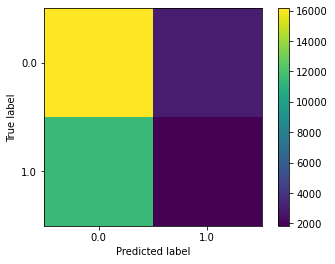

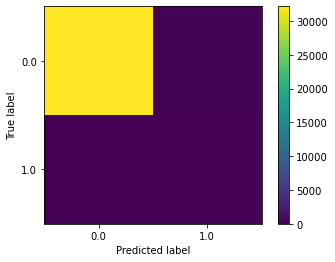

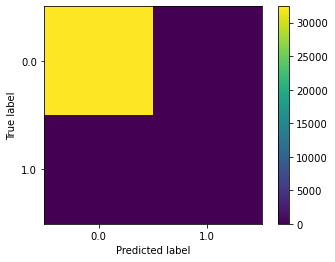

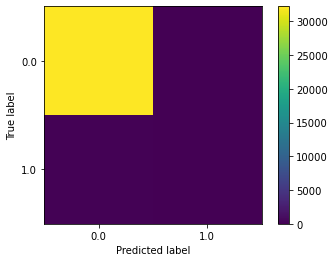

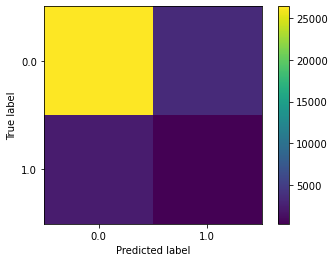

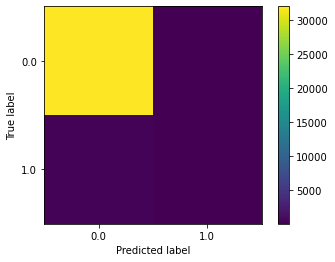

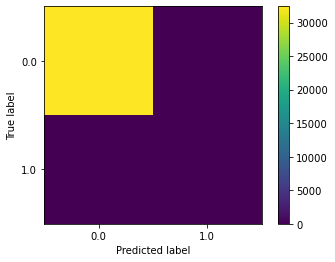

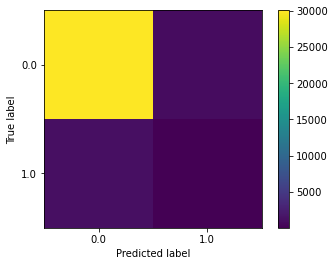

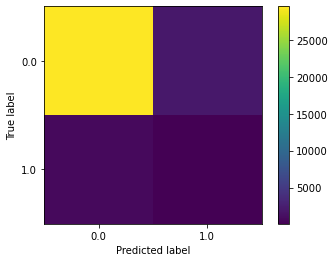

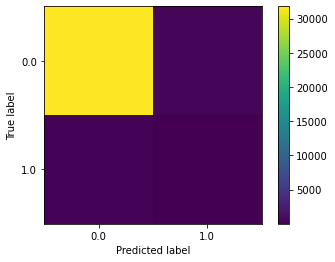

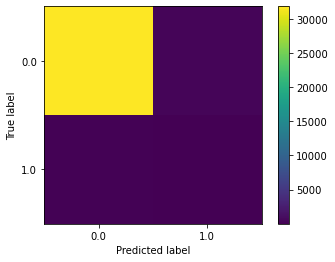

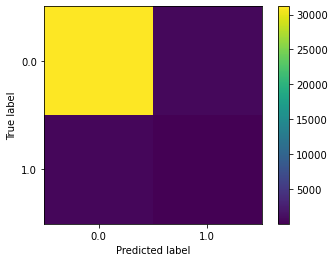

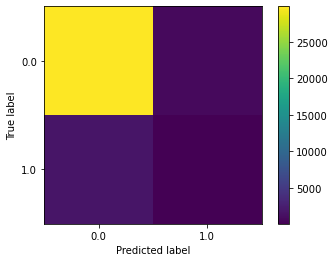

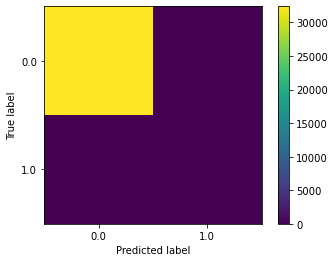

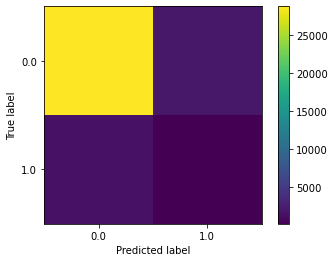

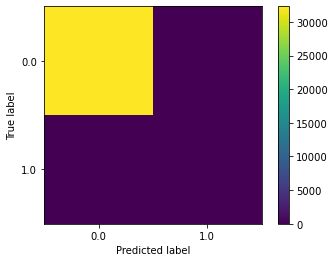

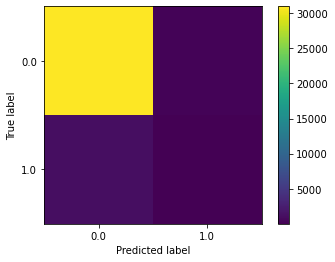

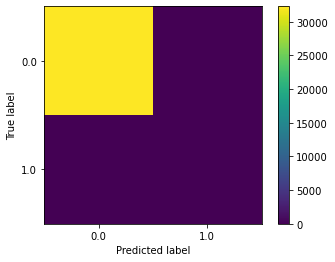

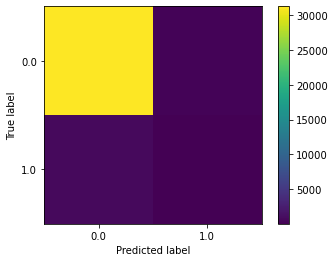

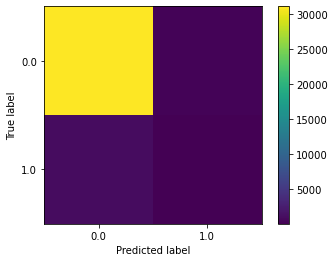

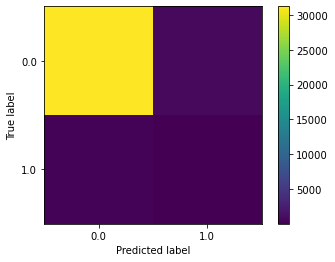

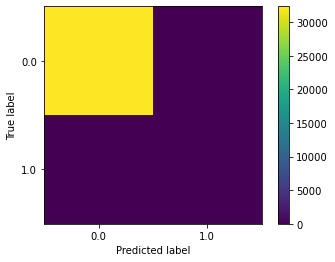

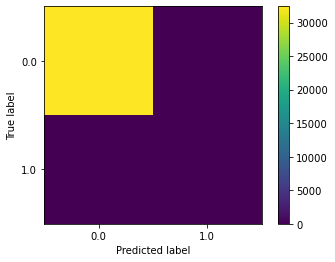

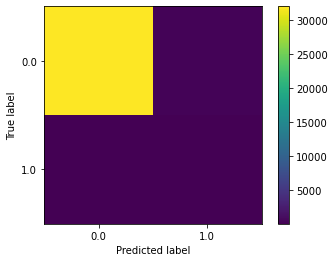

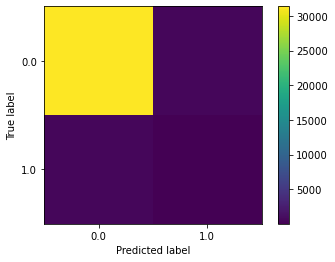

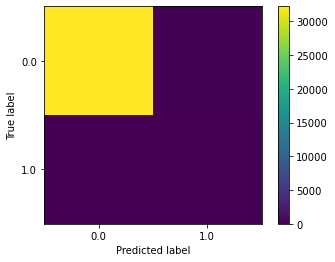

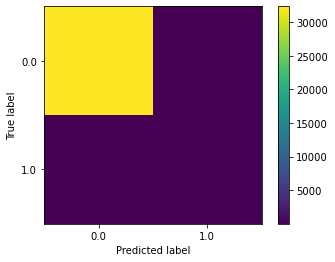

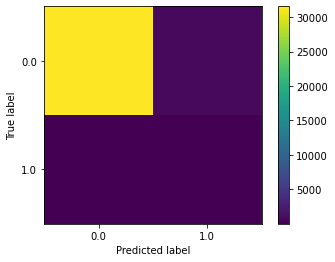

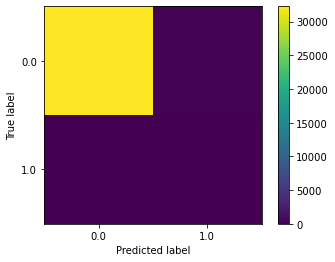

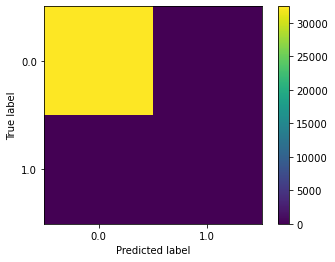

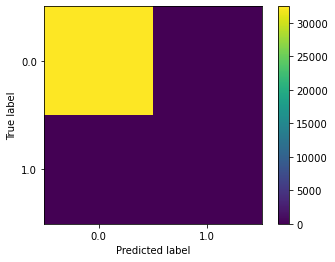

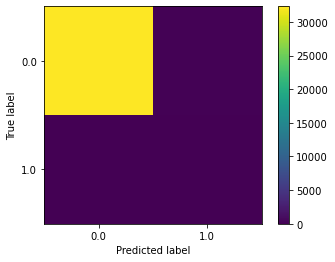

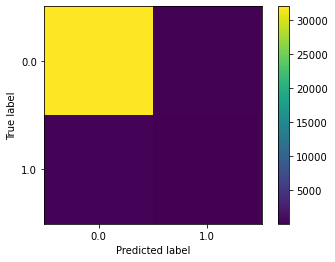

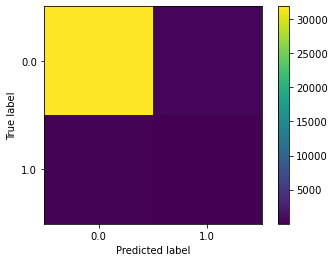

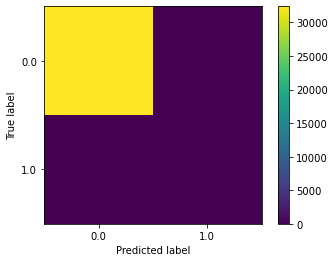

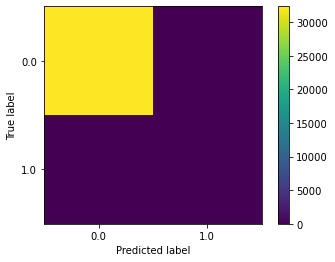

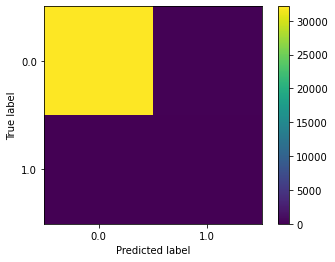

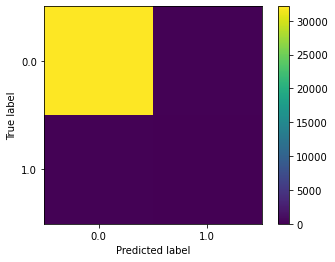

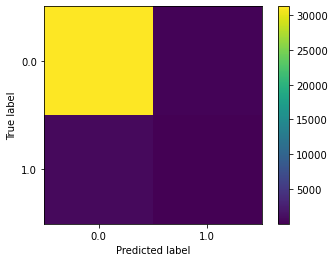

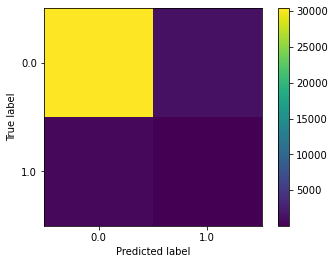

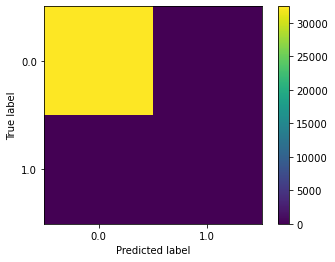

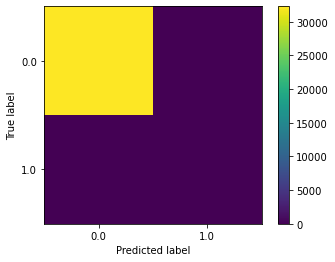

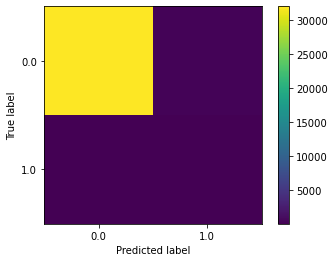

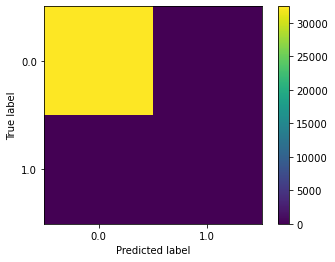

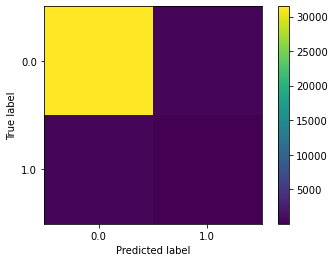

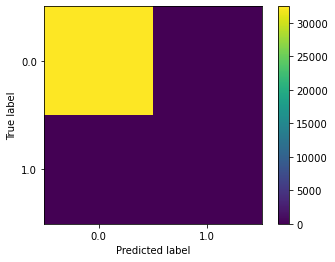

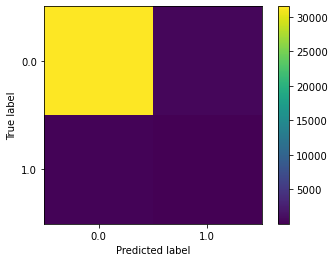

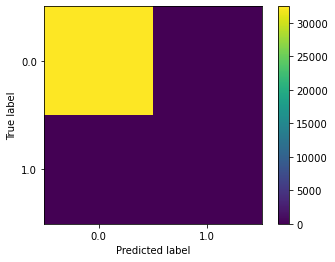

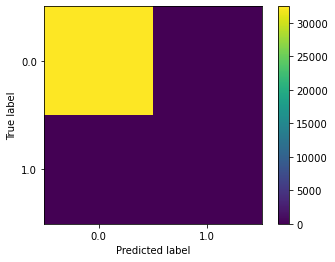

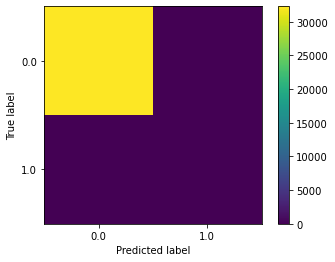

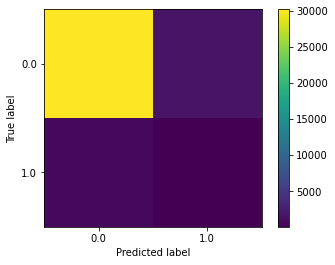

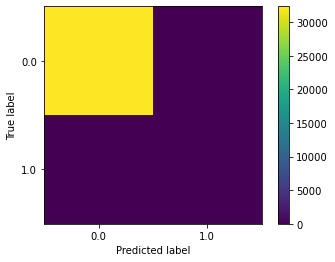

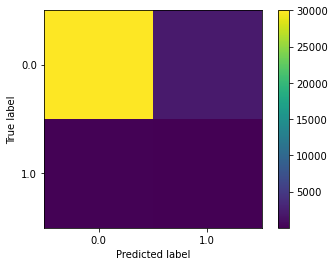

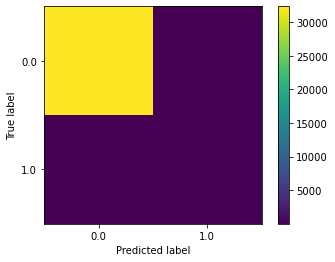

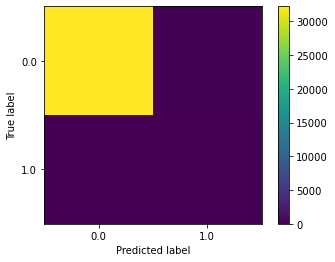

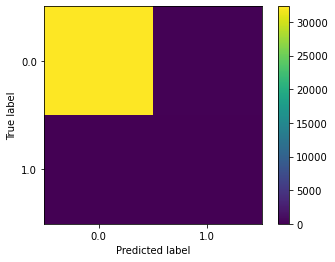

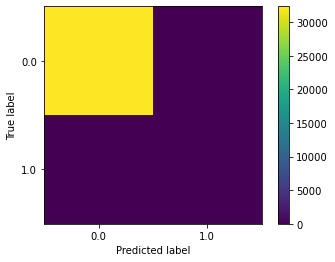

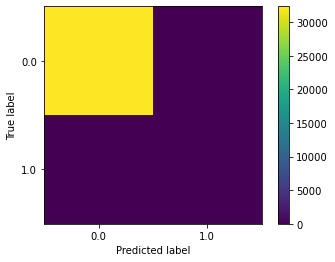

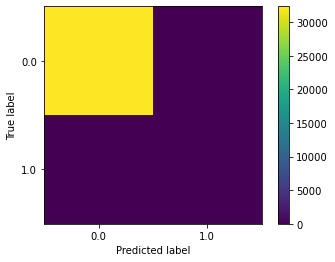

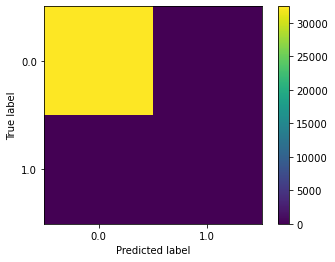

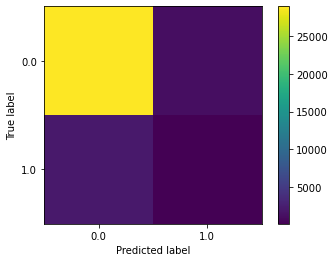

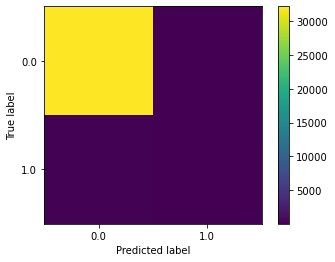

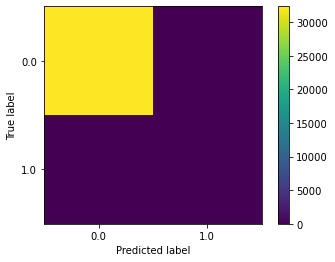

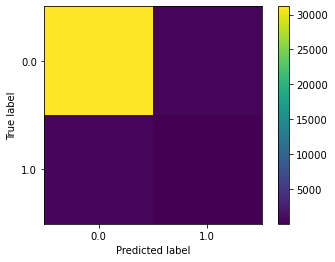

In [118]:
f, axes = plt.subplots(8, 8, figsize=(25, 25))
axes = axes.ravel()
for i, label in zip(range(64), label_list):
    disp = ConfusionMatrixDisplay.from_predictions(y_test_input.cpu().detach().numpy()[:, i],
                                                   out.cpu().detach().numpy()[:, i],
                                  include_values=False,
#                                   normalize="true",
#                                   display_labels=[0, i]
                                 )
    disp.plot(ax=axes[i])#, values_format='.4g')
    disp.ax_.set_title(f'{label}')
#     if i<10:
#         disp.ax_.set_xlabel('')
#     if i%5!=0:
#         disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()
f.suptitle(f"{RUN_NAME}", fontsize=20)

plt.subplots_adjust(wspace=0.20, hspace=0.2)
f.colorbar(disp.im_, ax=axes)
plt.show()


In [119]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

In [120]:
# precision_recall_fscore_support(y_test_input.cpu().detach().numpy(), out.cpu().detach().numpy())
class_report = pd.DataFrame(classification_report(y_test_input.cpu().detach().numpy(), out.cpu().detach().numpy(), 
                                                  output_dict=True,
                                                 target_names=label_list)).T


/gpfs/milgram/project/rtaylor/vs428/conda_envs/factcheck_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/milgram/project/rtaylor/vs428/conda_envs/factcheck_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/milgram/project/rtaylor/vs428/conda_envs/factcheck_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to con

In [121]:
with pd.option_context("display.max_rows", None):
    display(class_report.sort_values("support", ascending=False))


,precision,recall,f1-score,support
samples avg,0.068870,0.084589,0.072615,35570.0
micro avg,0.088765,0.081276,0.084856,35570.0
weighted avg,0.174848,0.081276,0.103164,35570.0
macro avg,0.018773,0.018240,0.015556,35570.0
"Abdominal Pain, general",0.387811,0.137177,0.202667,13406.0
Acute cystitis,0.088196,0.125048,0.103437,2623.0
Urolithiasis,0.111664,0.068619,0.085003,2288.0
Colitis,0.061224,0.028192,0.038607,1809.0
Constipation,0.062940,0.081016,0.070843,1654.0
Appendicitis,0.038596,0.033460,0.035845,1315.0
